In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma, lognorm
import seaborn as sns
from datetime import date

In [2]:
df = pd.read_table(
    "fits/rothman-sars_cov_2.tsv", 
    converters={"date": date.fromisoformat},
)
# TODO: Clean this up
df.loc[df.observation_type == "data", "draws"] = -1 # For faceting on "draws"
print(df)

        draws  sample  divergent__  n_leapfrog__        lp__  stepsize__   
0         0.0     1.0          0.0          15.0 -190.196885    0.411393  \
1         1.0     1.0          0.0          15.0 -187.482495    0.421749   
2         2.0     1.0          0.0           7.0 -181.362269    0.481071   
3         3.0     1.0          0.0           7.0 -163.326189    0.432320   
4         4.0     1.0          0.0           7.0 -194.959703    0.411393   
...       ...     ...          ...           ...         ...         ...   
388092   -1.0     NaN          NaN           NaN         NaN         NaN   
388093   -1.0     NaN          NaN           NaN         NaN         NaN   
388094   -1.0     NaN          NaN           NaN         NaN         NaN   
388095   -1.0     NaN          NaN           NaN         NaN         NaN   
388096   -1.0     NaN          NaN           NaN         NaN         NaN   

                b  treedepth__    energy__       phi  ...  y_tilde     theta   
0      

## Inverse overdispersion, $\phi$

<Axes: xlabel='phi', ylabel='Density'>

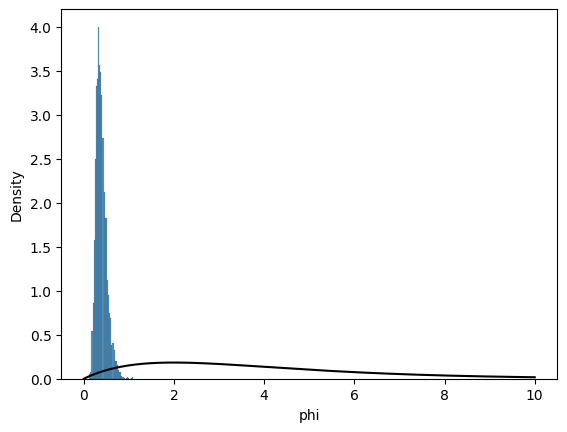

In [3]:
# Prior
x = np.linspace(0, 10, 1000)
sns.lineplot(
    x = x,
    y = gamma.pdf(x, 2.0, scale=2.0),
    color = "black",
)

# Posterior
sns.histplot(
    data=df[df["sample"] == 1],
    x="phi",
    stat="density",
    bins=40,
)

## Relative abundance per 1% prevalence

<Axes: xlabel='ra_per_one_percent', ylabel='Density'>

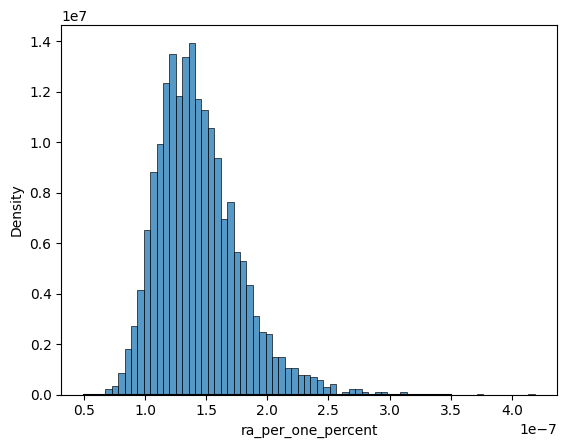

In [4]:
# Prior
x = np.linspace(0.5e-7, 3.5e-7, 1000)
sns.lineplot(
    x = x,
    y = lognorm.pdf(x, 10, loc=-3),
    color = "black",
)

# Posterior
sns.histplot(
    data=df[df["sample"] == 1],
    x="ra_per_one_percent",
    stat="density",
)

## Viral reads over time

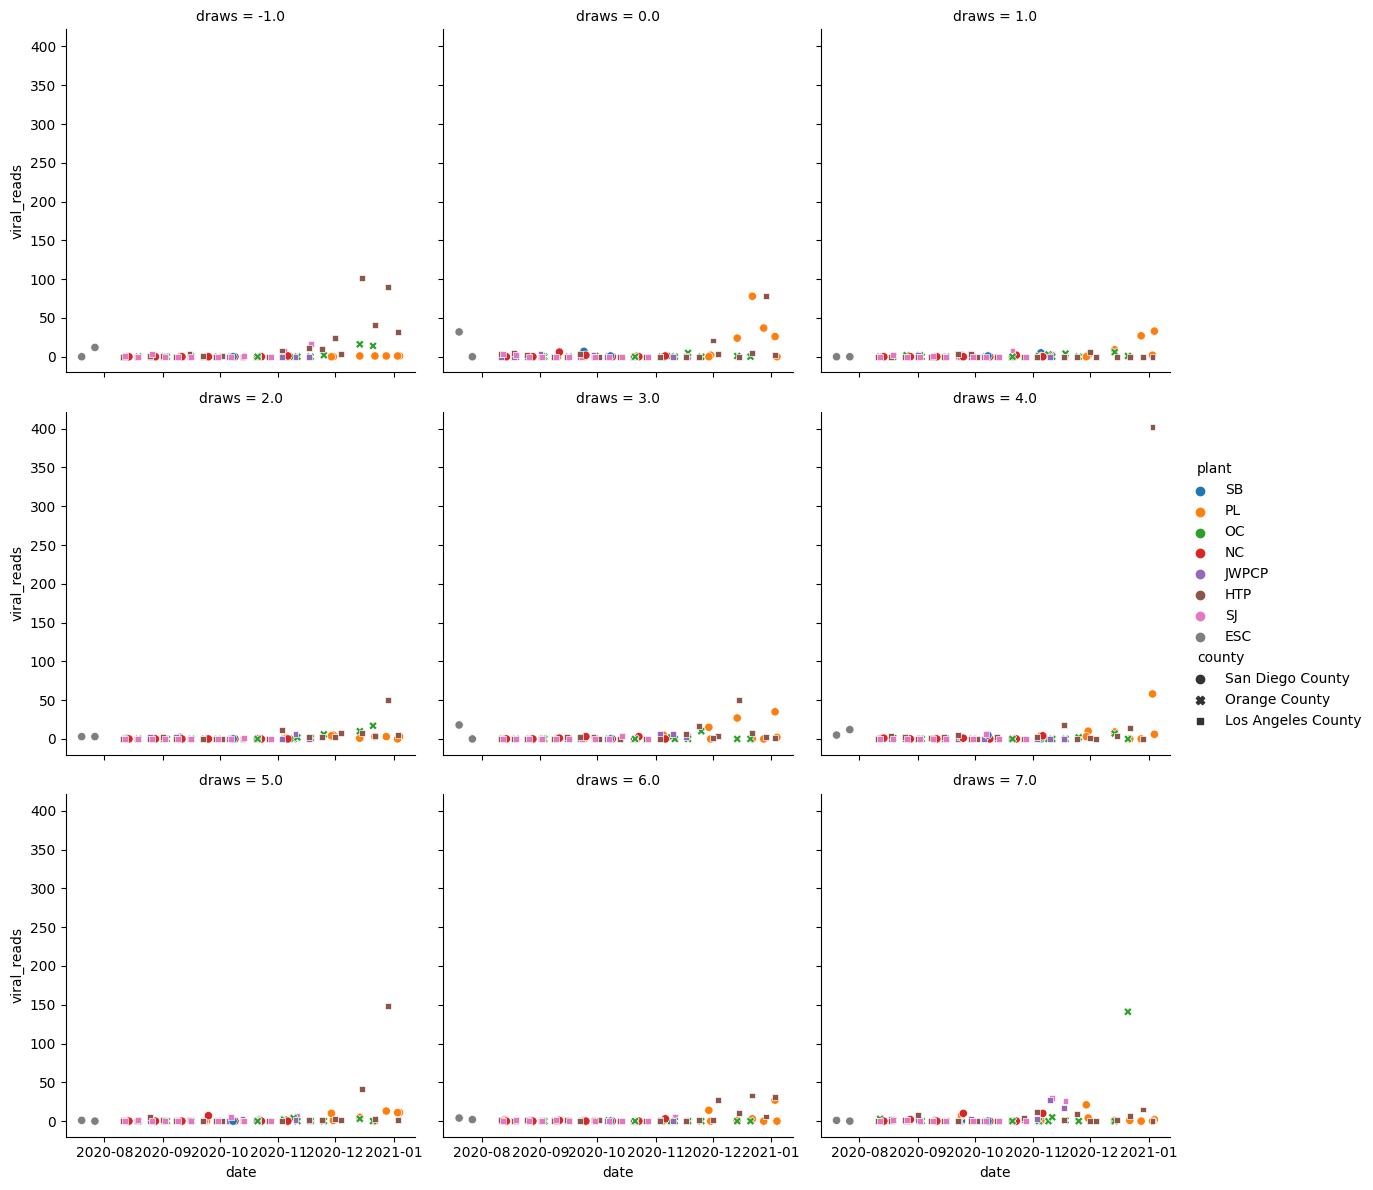

In [5]:
sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="viral_reads",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)

## Prevalence vs time

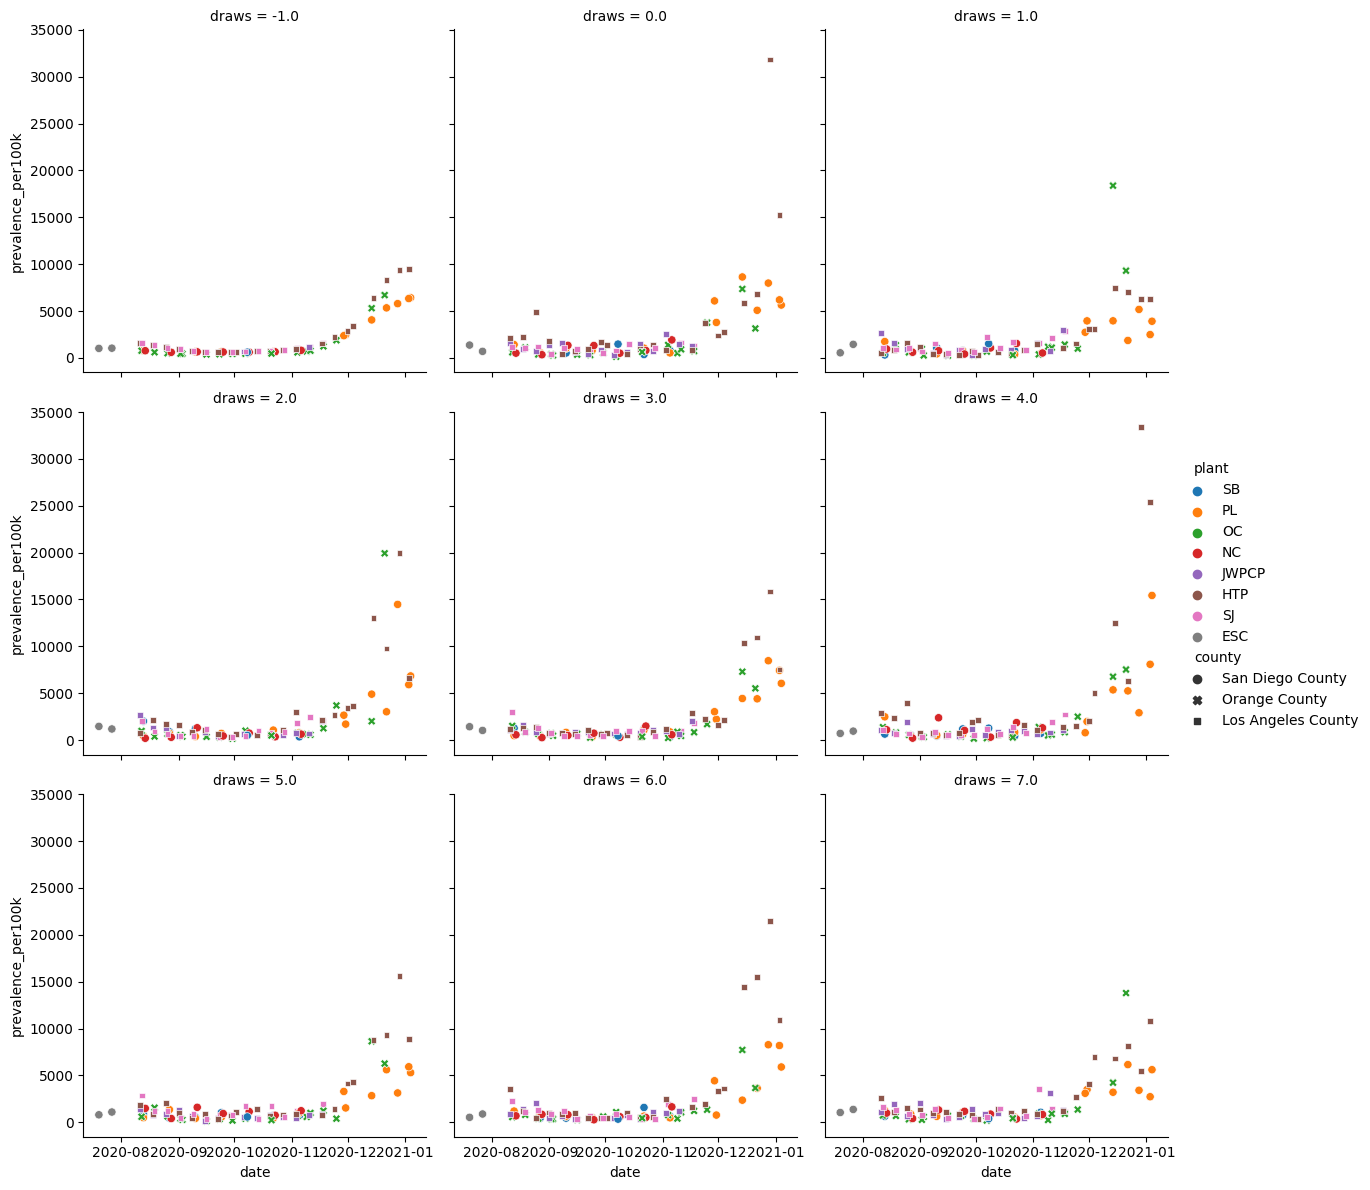

In [6]:
sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="prevalence_per100k",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)

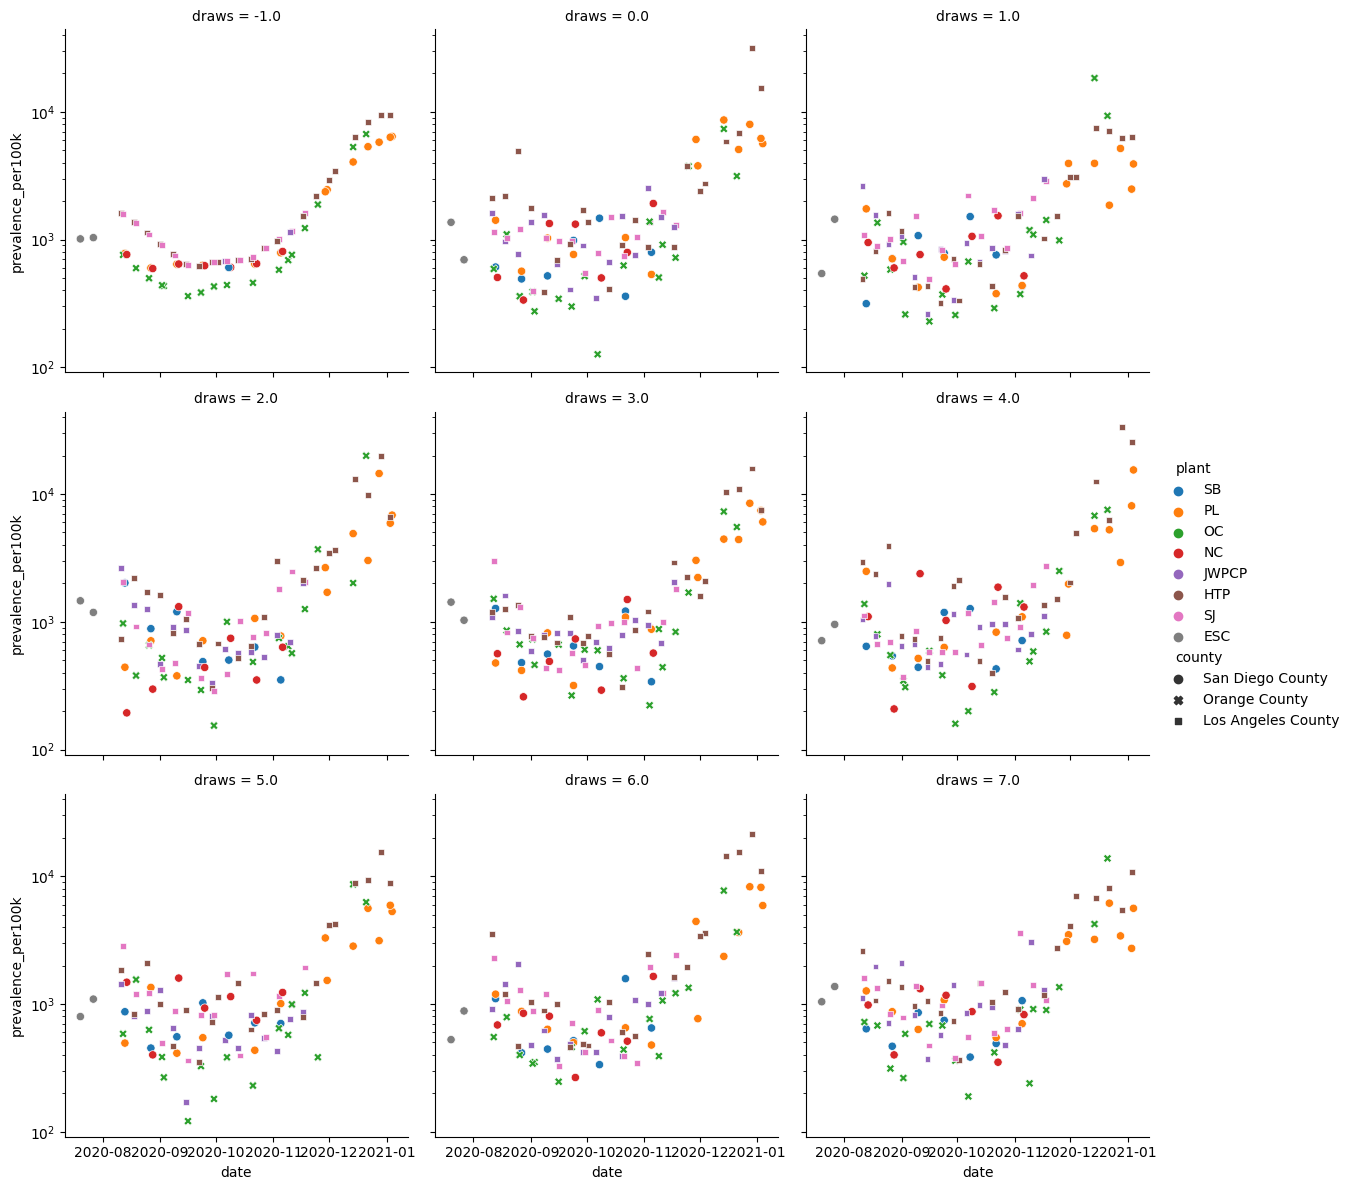

In [7]:
g = sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="prevalence_per100k",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)
g.set(yscale="log")

## Viral reads vs. prevalence

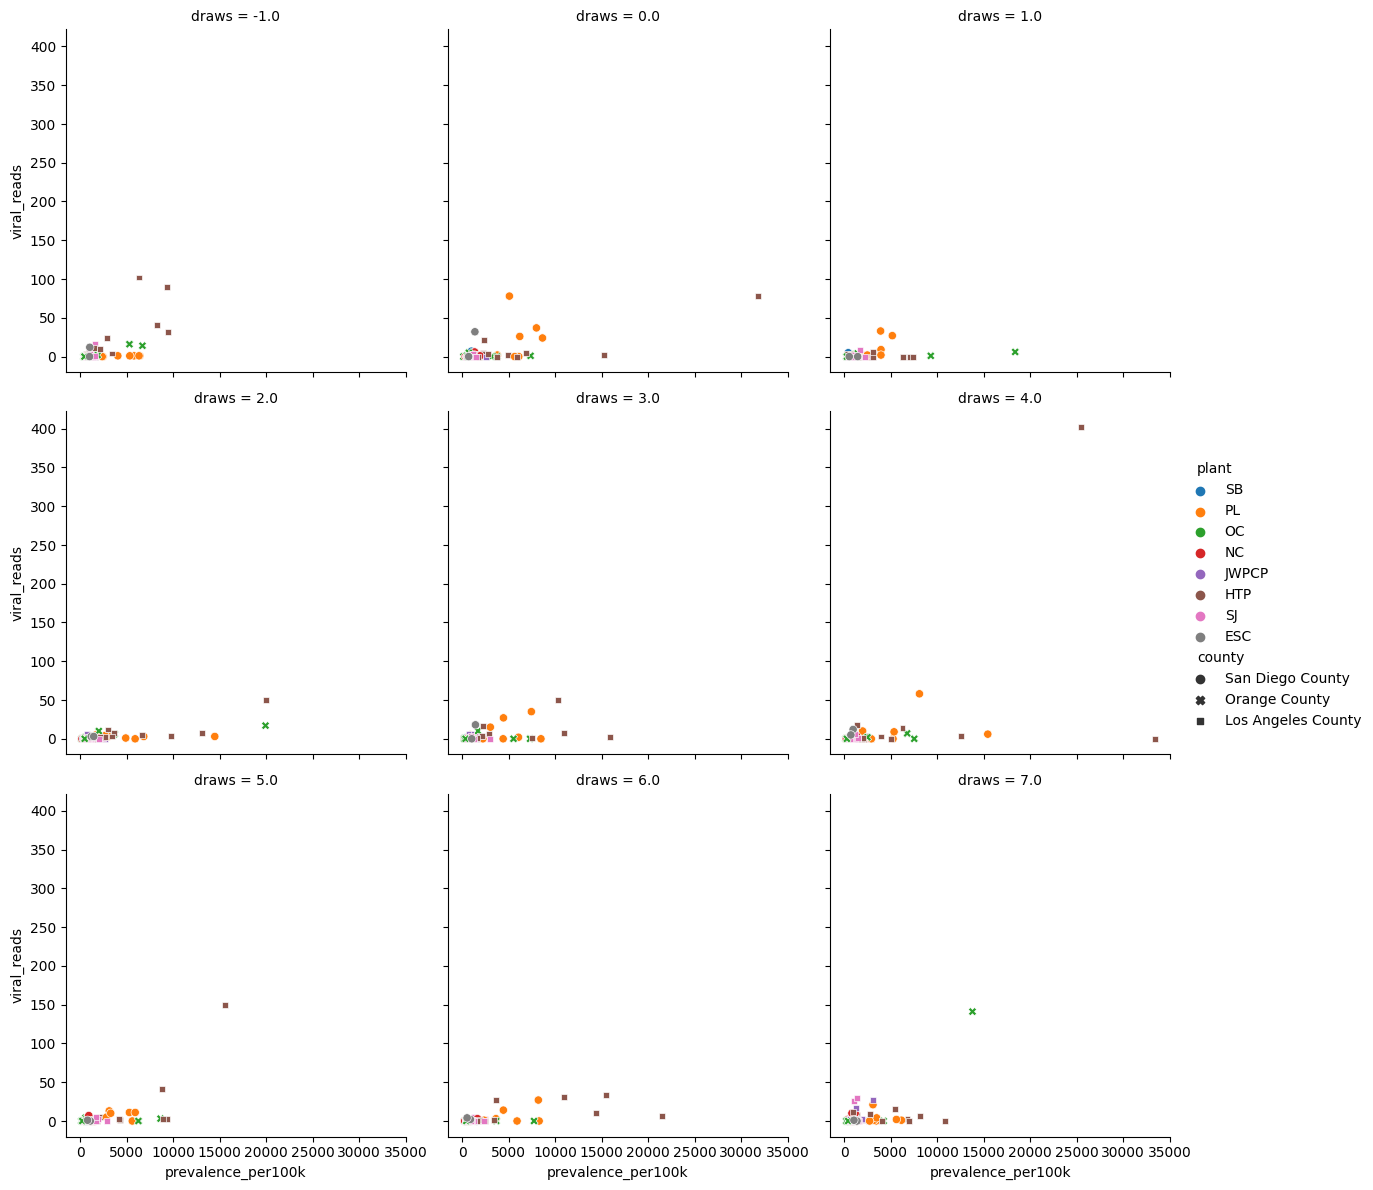

In [8]:
g = sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="prevalence_per100k",
    y="viral_reads",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)
# g.set(yscale="log")